<a href="https://colab.research.google.com/github/epb378/FRET-simulator/blob/master/fretsimulator3-functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded=files.upload()

Saving green extinction coefficient.csv to green extinction coefficient.csv
Saving red extinction coefficient.csv to red extinction coefficient.csv
Saving blue extinction coefficient.csv to blue extinction coefficient.csv
Saving bluemolem.csv to bluemolem.csv
Saving greenmolem.csv to greenmolem.csv
Saving redmolem.csv to redmolem.csv


(array([[4.25833333e-04, 6.21250000e-04, 1.27458333e-03, 1.68291667e-03,
         2.25458333e-03, 2.17000000e-03, 2.49666667e-03, 2.53750000e-03,
         2.10583333e-03, 2.25458333e-03, 2.26916667e-03, 2.51125000e-03,
         2.07375000e-03, 1.66250000e-03, 1.26291667e-03, 6.38750000e-04,
         4.11250000e-04, 1.98333333e-04, 1.48750000e-04, 6.12500000e-05,
         2.62500000e-05, 4.08333333e-05, 1.45833333e-05, 1.45833333e-05,
         2.91666667e-06, 2.91666667e-06, 2.91666667e-06, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.25833333e-04, 6.21250000e-04, 1.27458333e-03, 1.68291667e-03,
         2.25458333e-03, 2.17000000e-03, 2.49666667e-03, 2.53750000e-03,
         2.10583333e-03, 2.25458333e-03, 2.26916667e-03, 2.51125000e-03,
         2.07666667e-03, 1.72083333e-03, 2.36250000e-03, 5.27625000e-03,
         6.67333333e-03, 3.23458333e-03, 3.11791667e-03, 3.8675000

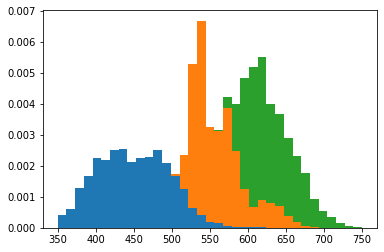

In [49]:

import scipy
import numpy as np
from scipy import stats
reddata=np.loadtxt('redmolem.csv',delimiter=',')
redwavelength=reddata[:,0]
greendata=np.loadtxt('greenmolem.csv',delimiter=',')
greenwavelength=greendata[:,0]
bluedata=np.loadtxt('bluemolem.csv',delimiter=',')
bluewavelength=bluedata[:,0]
redprob=reddata[:,1]
greenprob=greendata[:,1]
blueprob=bluedata[:,1]
redcustm = stats.rv_discrete(name='redcustm', values=(redwavelength, redprob))
greencustm = stats.rv_discrete(name='greencustm', values=(greenwavelength, greenprob))
bluecustm = stats.rv_discrete(name='bluecustm', values=(bluewavelength, blueprob))
import matplotlib.pyplot as plt
import seaborn as sns
x=np.zeros((10000,3))
x[:,0]=bluecustm.rvs(size=10000)
x[:,1]=greencustm.rvs(size=10000)
x[:,2]=redcustm.rvs(size=10000)
colors = ['blue', 'green', 'red']

plt.hist(x, 35, density=True, histtype='bar', stacked=True) #plot randomly sampled wavelngths from emission distribution
#print(custm.rvs(size=100))

In [0]:
moltomolecule=1 #ratio of molar extinction coefficient to molecular
redabs=np.loadtxt('red extinction coefficient.csv',delimiter=',')
greenabs=np.loadtxt('green extinction coefficient.csv',delimiter=',')
blueabs=np.loadtxt('blue extinction coefficient.csv',delimiter=',')

def combinedexctinction (redabs,greenabs,blueabs,Nr,Ng,Nb): 
  redwave=redabs[:,0]
  greenwave=greenabs[:,0]
  bluewave=blueabs[:,0]
  redexct=redabs[:,1]
  greenexct=greenabs[:,1]
  blueexct=blueabs[:,1]
  #the below is for 300-700 nm exctinction coefficiencts with a nm step of 1 - could try variable length later...
  combined=np.zeros([redwave.size,5])
  combined[:,0]=redwave
  combined[:,1]=Nb*blueexct*moltomolecule
  combined[:,2]=Ng*greenexct*moltomolecule
  combined[:,3]=Nr*redexct*moltomolecule
  combined[:,4]=combined[:,1]+combined[:,2]+combined[:,3]
  return combined
totalextinction=combinedexctinction(redabs,greenabs,blueabs,2,20,20)

In [0]:
def populategrid(molecules,distances,Nr,Ng,Nb, Xmax, Ymax, Zmax,Ri):
  from random import randint

  Ntot=Ng+Nr+Nb
  
  for i in range (0,Ntot):
    
    molecules[i,1]=randint(1,Xmax)
    molecules[i,2]=randint(1,Ymax)
    molecules[i,3]=randint(1,Zmax)
    if i>0:
        for j in range(0,i):
            distances[i,j]=np.sqrt((molecules[i,1]-molecules[j,1])**2 + (molecules[i,2]-molecules[j,2])**2 + (molecules[i,3]-molecules[j,3])**2)
            distances[j,i]=distances[i,j]
            if distances[i,j]<(Ri[int(molecules[i,0]-1)]+Ri[int(molecules[j,0]-1)]):
                i = i-1
  return molecules,distances

In [0]:
def FRETTING(distances,excitindex,Ntot,molecules,Ros,PLQEs,closest,somethinghappened, outspectrum,redcustm,greencustm,bluecustm):
    zeroNtot=np.arange(Ntot)
    zeroNtot.shape=(Ntot,1)
    while somethinghappened == 0:
        a=distances[:,excitindex] #find distances to closest molecules
        a.shape=(Ntot,1)
        indexeddistances= np.concatenate((zeroNtot,a), axis=1)
        indexeddistances= indexeddistances[indexeddistances[:,1].argsort()] #find index of closest molecule
        if molecules[int(indexeddistances[closest,0]),0] > molecules[excitindex,0]:
            dice=np.random.random()
            Pfret=1/(1+(indexeddistances[closest,1]/Ros[int(molecules[excitindex,0]-1),int(molecules[int(indexeddistances[closest,0]),0]-1)])**6) #fret probability
            
            Pem=Pfret + (1-Pfret)*PLQEs[int(molecules[excitindex,0]-1)]
            
            if dice<=Pfret:
                molecules[excitindex,4]=0
                molecules[int(indexeddistances[closest,0]),4]=1
                excitindex=int(indexeddistances[closest,0])
                somethinghappened=0
            elif Pfret< dice <= Pem:
                if color==3:
                  outspectrum[i]=redcustm.rvs()
                elif color==2:
                  outspectrum[i]=greencustm.rvs()
                else:
                  outspectrum[i]=bluecustm.rvs()
                somethinghappened=1
            else:
                #print("non-radiative recombination, bozo")
                somethinghappened=1
        else:
            closest= closest+1
            if closest==Ntot:
              break
    return excitindex, molecules, closest, outspectrum

In [0]:
def exciterandomblue (molecules,Nb, printing=False):
  findblues=np.where(molecules[:,0]==1) #excite random blue
  bluesarray=findblues[0]
  excitint=random.randint(0,Nb-1)
  excitindex=bluesarray[excitint]
  if printing==True:
    print("start molecule is number ")
    print( excitindex)
  molecules[:,4]=0
  molecules[excitindex,4]=1
  return molecules, excitindex
#exciterandomblue(molecules,Nb)

PLQE=
0.1999199919991999


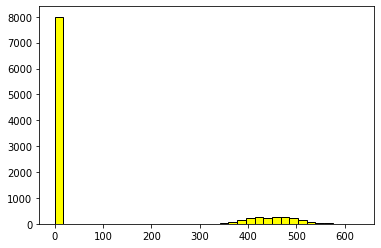

In [109]:
from mpl_toolkits.mplot3d import Axes3D #(3D scatter https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html)
#import numpy as np
import matplotlib.pyplot as plt
import math
import random
#set up grid of Xmax*Ymax*Zmax points

#populate grid with Nb blue molecules, Ng greens, and Nr reds
Nb = 20
blues=np.ones([Nb,1])
gtb=1
Ng = Nb*gtb
greens=np.ones([Ng,1])
greens=greens*2
rtg=0.1
Nr = math.floor(Ng*rtg)
reds=np.ones([Nr,1])
reds=reds*3 
Ntot=Nb+Ng+Nr

###spatial units are nm###NB perylene density =1.3g/cm3. molar mass=252.3g/mol => 3e21 cm-3 =3nm-3
Ri=np.array([[2],[2.4],[3.25]])
dyenumberdensity=0.01 #molecules/nm3
xyz=int(Ntot/dyenumberdensity)
Xmax, Ymax, Zmax = xyz, xyz, xyz
###nm resolution grid###
Ros=np.array([[4,4.5,4.8],[0.01,4,8.9],[0.01,0.01,4]])
PLQEs=np.array([0.2,0.9,0.99])

molecules=np.concatenate((reds,greens,blues))
#print(molecules)
np.random.shuffle(molecules)
rest=np.zeros([Ntot,4])
molecules=np.concatenate((molecules,rest), axis=1)
distances=np.zeros([Ntot,Ntot])
molecules, distances=populategrid(molecules,distances,Nr,Ng,Nb, Xmax, Ymax, Zmax,Ri)
       
ticks=10000
outspectrum=np.zeros([ticks])
findblues=np.where(molecules[:,0]==1)
bluesarray=findblues[0]
excitint=random.randint(0,Nb-1)
excitindex=bluesarray[excitint]
molecules[:,4]=0
molecules[excitindex,4]=1
combinedabs=combinedexctinction (redabs,greenabs,blueabs,Nr,Ng,Nb)
for i in range (0,ticks):
#    print(i)
    molecules,excitindex=exciterandomblue(molecules,Nb)
    color=molecules[excitindex,0]
    somethinghappened=0
    closest=1
    excitindex, molecules, closest, outspectrum = FRETTING(distances,excitindex,Ntot,molecules,Ros,PLQEs,closest,somethinghappened, outspectrum,redcustm,greencustm,bluecustm)
   
plt.hist(outspectrum, color = 'yellow', edgecolor = 'black',
         bins = int((700-350)/10)) 
outnonzero=np.count_nonzero(outspectrum)

outPLQE=outnonzero/(i)
print('PLQE=')
print(outPLQE)

(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  9., 31., 15., 16.,  3.,  8.,  1.,  5.]),
 array([  0.        ,  18.91428571,  37.82857143,  56.74285714,
         75.65714286,  94.57142857, 113.48571429, 132.4       ,
        151.31428571, 170.22857143, 189.14285714, 208.05714286,
        226.97142857, 245.88571429, 264.8       , 283.71428571,
        302.62857143, 321.54285714, 340.45714286, 359.37142857,
        378.28571429, 397.2       , 416.11428571, 435.02857143,
        453.94285714, 472.85714286, 491.77142857, 510.68571429,
        529.6       , 548.51428571, 567.42857143, 586.34285714,
        605.25714286, 624.17142857, 643.08571429, 662.        ]),
 <a list of 35 Patch objects>)

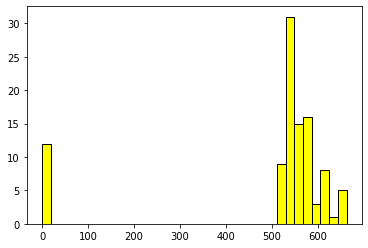